# tmp — may24

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
device_idx = 3
device = f'cuda:{device_idx}'

from figures.imgs import plot_weights

In [15]:
import torch

def poisson_density_check(rate, n_exp, temperature, num_samples=100000):
    exp = torch.distributions.Exponential(rate)
    samples = exp.sample((num_samples, n_exp))
    times = torch.cumsum(samples, dim=1)
    
    if temperature == 0:
        indicator = (times < 1.0).float()
    else:
        indicator = torch.sigmoid((1.0 - times) / temperature)
    
    z = indicator.sum(dim=1)
    
    # Estimate the density
    density_estimate = z.mean().item()
    
    return density_estimate

rate = torch.tensor([1.0])
n_exp = 100
temperature = 0.0

In [16]:
density_estimate = poisson_density_check(rate, n_exp, temperature)
print(f"Estimated density: {density_estimate}")

Estimated density: 1.0006500482559204

In [18]:
temps = np.array(sorted([0.0, 0.05, 0.1, 0.5, 1.0, 5.0]))
temps = temps[::-1]

for t in temps:
    density_estimate = poisson_density_check(rate, n_exp, t)
    print(f"temperature: {t} ——— density estimate: {density_estimate:0.4f}")

temperature: 5.0 ——— density estimate: 3.9930

temperature: 1.0 ——— density estimate: 1.3136

temperature: 0.5 ——— density estimate: 1.0623

temperature: 0.1 ——— density estimate: 0.9985

temperature: 0.05 ——— density estimate: 0.9980

temperature: 0.0 ——— density estimate: 1.0066

In [23]:
for ds in ['DOVES', 'CIFAR10-PATCHES']:#, 'MNIST']:
    tr = TrainerVAE(
        MODEL_CLASSES['poisson'](CFG_CLASSES['poisson'](dataset=ds, enc_type='conv', dec_type='conv', save=False)),
        ConfigTrainVAE(),
        device=device,
    )
    print(ds, tr.dl_trn.dataset.tensors[0].shape, tr.dl_vld.dataset.tensors[0].shape)

DOVES
torch.Size([107520, 1, 16, 16])
torch.Size([28224, 1, 16, 16])

CIFAR10-PATCHES
torch.Size([200000, 1, 16, 16])
torch.Size([40000, 1, 16, 16])

In [24]:
tr.model.cfg.name()

'poisson_uniform_c(-2)_CIFAR10-PATCHES_z-512_k-32_<conv|conv>'

In [25]:
print(tr.model.enc)

Sequential(
  (0): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0-1): 2 x ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (1): Cell(
    (skip): FactorizedReduce(
      (swish): SiLU()
      (ops): ModuleList(
        (0-3): 4 x Conv2D(32, 16, kernel_size=(1, 1), stride=(2, 2))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (2): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0-1): 2 x ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (3): Cell(
    (skip): FactorizedReduce(
      (swish): SiLU()
      (ops): ModuleList(
        (0-3): 4 x Conv2D(64, 32, kernel_size=(1, 1), stride=(2, 2))
      )
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
      (1): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (4): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0-1): 2 x ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (5): ResConvPool(
    (act_fn): SiLU()
    (pool): AdaptiveAvgPool2d(output_size=(1, 1))
    (conv): Conv2D(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=valid)
  )
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): ResDenseLayer(
    (fc1): Linear(in_features=128, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=128, bias=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (drop): Dropout(p=0.1, inplace=False)
    (relu): ReLU()
  )
)

In [26]:
len(tr.model.enc) - 3, len(tr.model.dec)

(5, 8)

In [21]:
print(tr.model.dec)

Sequential(
  (0): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=256, out_features=16, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=16, out_features=256, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (1): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(256, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (2): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=8, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=128, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (3): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(128, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (4): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=64, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=64, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (5): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(64, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')
        (act_fn): SiLU()
        (conv): Conv2D(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (6): Cell(
    (skip): Identity()
    (ops): ModuleList(
      (0): ConvLayer(
        (act_fn): SiLU()
        (conv): Conv2D(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (se): SELayer(
      (fc): Sequential(
        (0): Linear(in_features=32, out_features=4, bias=True)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=4, out_features=32, bias=True)
        (3): Sigmoid()
      )
    )
  )
  (7): Upsample(size=14, mode='nearest')
  (8): Cell(
    (skip): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2D(32, 16, kernel_size=(1, 1), stride=(1, 1))
    )
    (ops): ModuleList(
      (0): ConvLayer(
        (upsample): Upsample(scale_factor=2.0, mode='nearest')


In [6]:
selected = [
    f for f in os.listdir(pjoin(git_dir, '_PoissonVAE', 'logs'))
    if not ('<conv+b|lin>' in f and '-b' in f)
]
len(selected)

975

In [7]:
975 / 5

195.0

In [4]:
sorted(os.listdir(pjoin(fig_base_dir, 'selected_ista_lca')))

['fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-100_seed-1.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-100_seed-2.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-100_seed-3.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-100_seed-4.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-100_seed-5.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-500_seed-1.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-500_seed-2.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-500_seed-3.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-500_seed-4.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-500_seed-5.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-900_seed-1.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-900_seed-2.png',
 'fista_lamb-0.05:0.5:0.05_lr-0.001:0.001_iter-900_seed-3.png',
 'fista_lamb-0.05:0.7:0.05_lr-0.001:0.001_iter-100_seed-1.png',
 'fista_lamb-0.05:0.7:0.05_lr-0.001:0.001_iter-100_seed-2.png',
 'fista_lamb-0.05:0.7:0.05_lr-0.001:0.00

In [10]:
run = np.load(pjoin(root, f"{best_fista}.npz"))
run

NpzFile '/home/hadi/Dropbox/chkpts/FISTA/fista_lamb-0.1:1.0:0.1_lr-0.001:0.001_iter-900_seed-1.npz' with keys: recons, activations, dictionary

In [19]:
y, z, phi = run['recons'], run['activations'], run['dictionary']

In [20]:
from figures.imgs import plot_weights

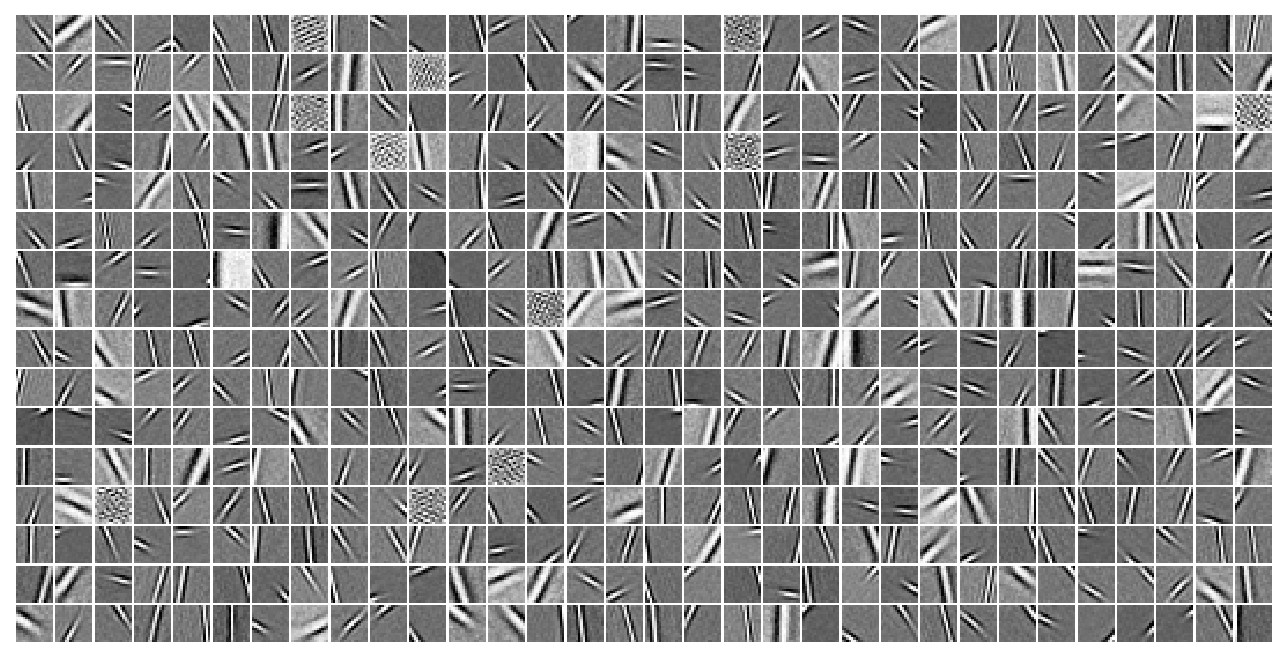

In [24]:
plot_weights(phi.T.reshape(-1, 16, 16))
plt.show()

In [23]:
name = 'poisson-<conv+b|lin>-DOVES-mc_solo-2_(2024_05_14,19:37)'
root = 'Dropbox/chkpts/PoissonVAE'

tr, meta = load_quick(
    pjoin(add_home(root), name),
    device=device,
    verbose=False,
    lite=True,
)
data, loss, etc = tr.validate()
dead = tr.find_dead_neurons(loss['kl_diag'])

In [24]:
dead.sum()

96

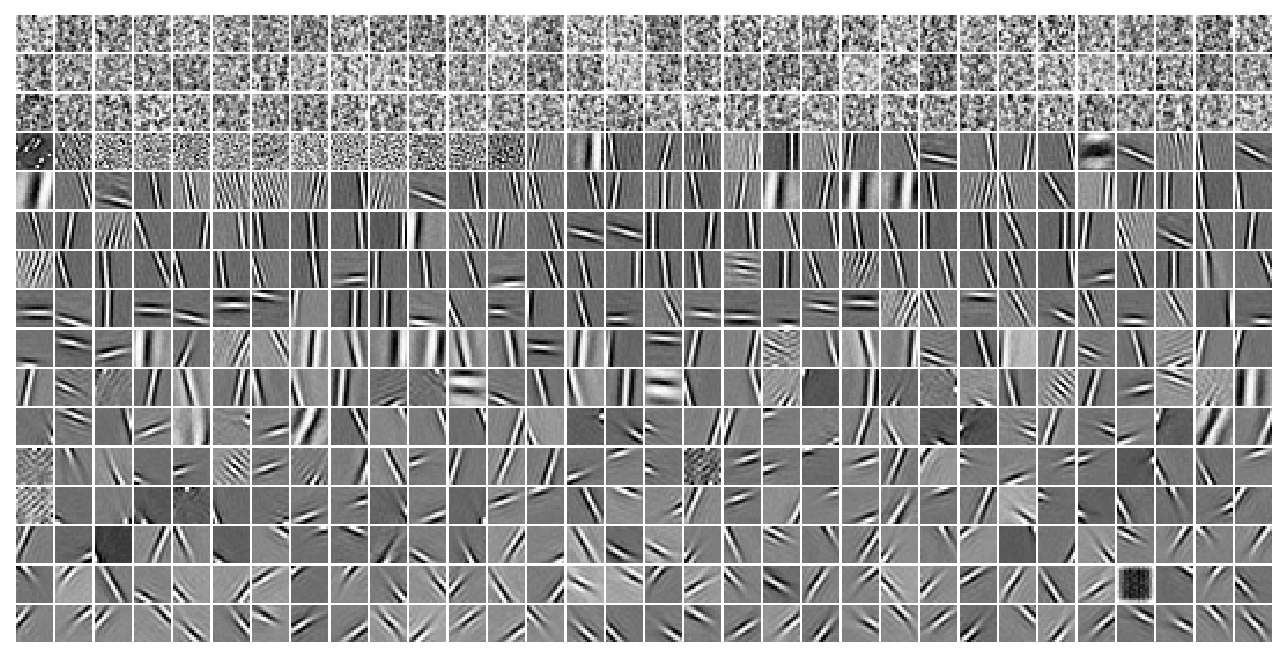

In [25]:
tr.model.show(order=np.argsort(loss['kl_diag']));

In [26]:
loss['mse'].mean()

134.46986

In [27]:
mse_map = []
for x, *_ in iter(tr.dl_vld):
    with torch.inference_mode():
        dist = tr.model.infer(x)[0]
        y = tr.model.decode(dist.mean)
        mse_map.append(tr.model.loss_recon(y, x))
mse_map = tonp(torch.cat(mse_map).mean())
mse_map

array(102.747505, dtype=float32)

In [28]:
name = 'categorical-<lin|lin>-MNIST-mc_mach-1_(2024_05_14,16:55)'
root = 'Dropbox/chkpts/PoissonVAE'

tr, meta = load_quick(
    pjoin(add_home(root), name),
    device=device,
    verbose=False,
    lite=True,
)
data, loss, etc = tr.validate()
dead = tr.find_dead_neurons(loss['kl_diag'])

In [31]:
loss['mse'].mean()

33.704292

In [34]:
mse_map = []
for x, *_ in iter(tr.dl_vld):
    with torch.inference_mode():
        dist = tr.model.infer(x)
        if isinstance(dist, tuple):
            dist = dist[0]
        y = tr.model.decode(dist.mean)
        mse_map.append(tr.model.loss_recon(y, x))
mse_map = tonp(torch.cat(mse_map).mean())
mse_map

array(32.05656, dtype=float32)

In [ ]:
d

### Test: ```<lin|lin>```

In [3]:
root = add_home('Dropbox/chkpts/PoissonVAE')

models2load = {
    'poisson': 'poisson-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:46)',
    'categorical': 'categorical-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:04)',
    'gaussian': 'gaussian-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:09)',
    'laplace': 'laplace-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:12)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [4]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 262.7 K

# params: 262.7 K

# params: 394.2 K

# params: 394.2 K

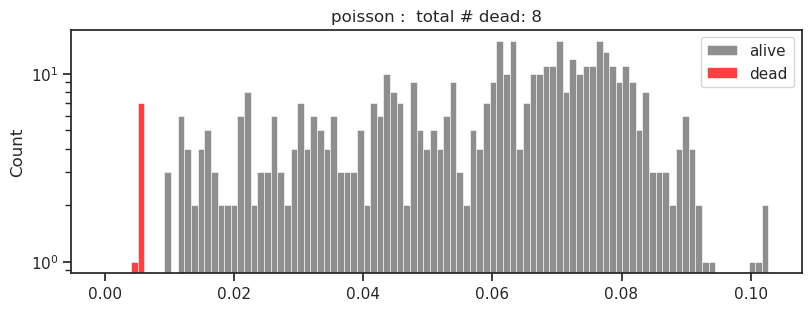

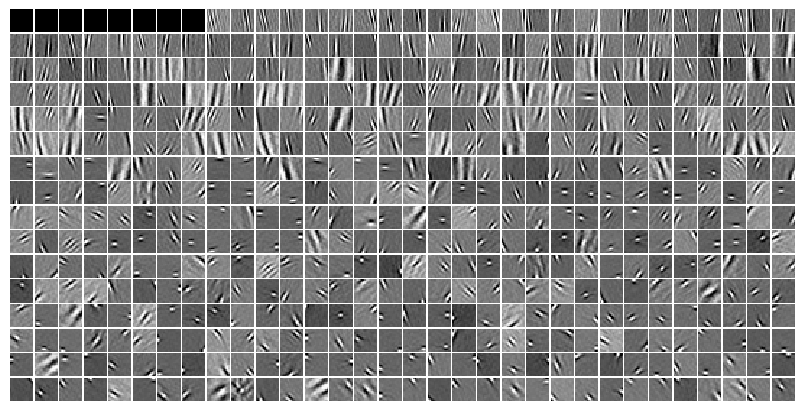

categorical :  total # dead: 3

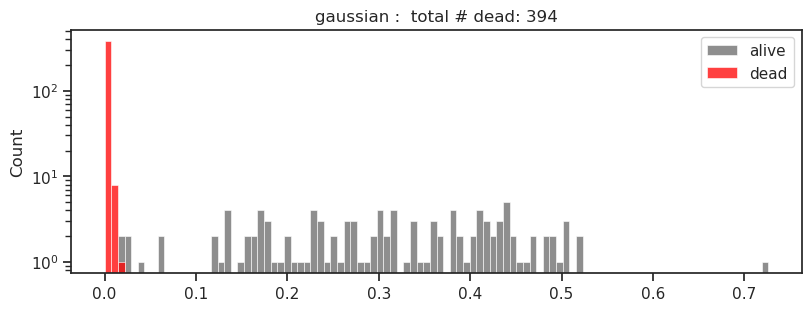

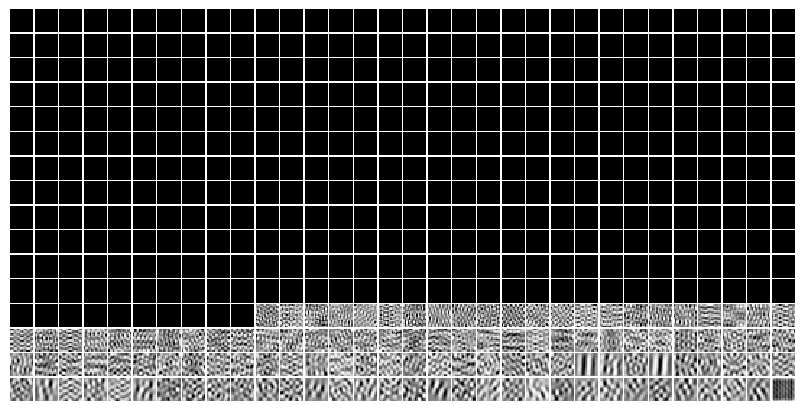

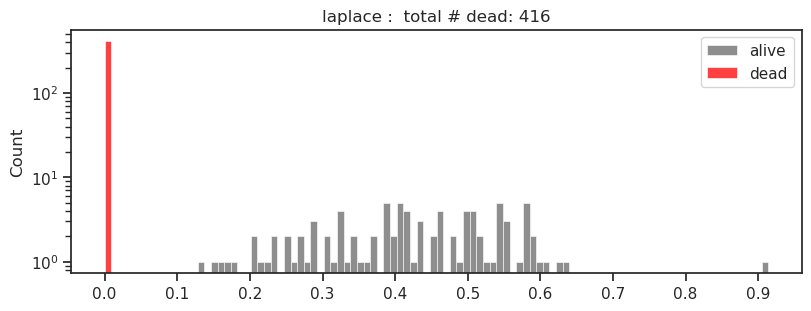

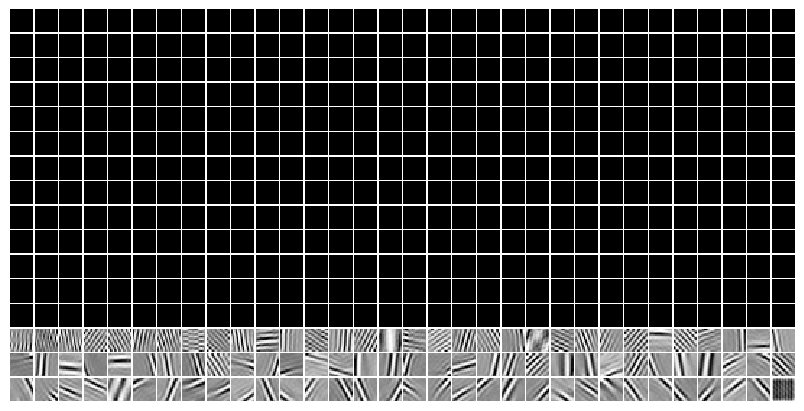

In [5]:
for name, tr in trainers.items():
    data, loss, etc = tr.validate()
    dead = tr.find_dead_neurons(loss['kl_diag'])

    msg = f"{name} :  total # dead: {dead.sum()}"
    if tr.model.cfg.type == 'categorical':
        print(msg)
        continue

    w_dec = tonp(tr.model.fc_dec.weight)
    norms = sp_lin.norm(w_dec, axis=0)
    w_dec = w_dec.T.reshape(-1, 16, 16)

    kl = loss['kl_diag']
    order = np.argsort(kl)
    
    w_dec = w_dec[order]
    norms = norms[order]
    dead = dead[order]
    kl = kl[order]

    fig, ax = create_figure(1, 1, (8, 3))
    bins = np.linspace(0, max(kl), 101)
    sns.histplot(kl[~dead], bins=bins, color='dimgrey', label='alive', ax=ax)
    sns.histplot(kl[dead], bins=bins, color='r', label='dead', ax=ax)
    ax.locator_params(axis='x', nbins=11)
    ax.set(yscale='log')
    ax.set_title(msg)
    ax.legend()
    plt.show()

    _ = plot_weights(w_dec, scaling=(~dead).astype(float), dpi=100)

### Test: ```<conv+b|lin>```

In [6]:
root = add_home('Dropbox/chkpts/PoissonVAE')

models2load = {
    'poisson': 'poisson-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_14,07/13)',
    'categorical': 'categorical-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_16,21/55)',
    'gaussian': 'gaussian-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_14,06/04)',
    'laplace': 'laplace-<conv+b|lin>-DOVES-mc_solo-1_(2024_05_17,00/00)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [7]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 1.4 M

# params: 1.4 M

# params: 1.5 M

# params: 1.5 M

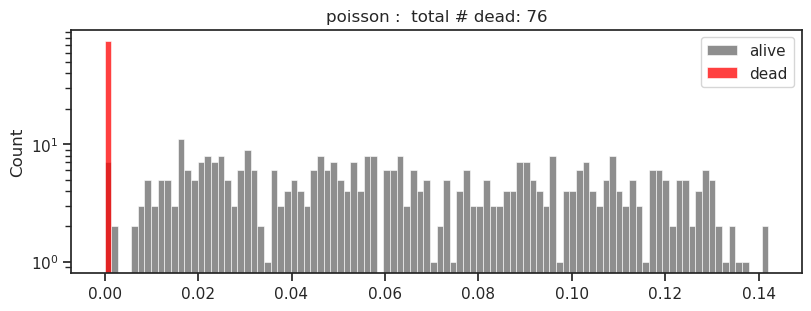

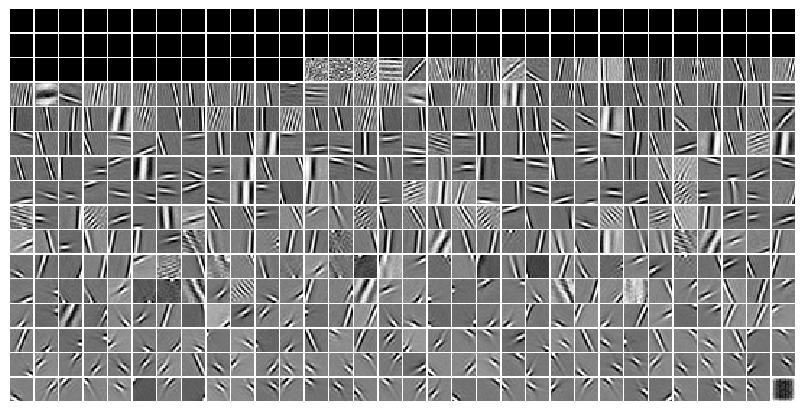

categorical :  total # dead: 2

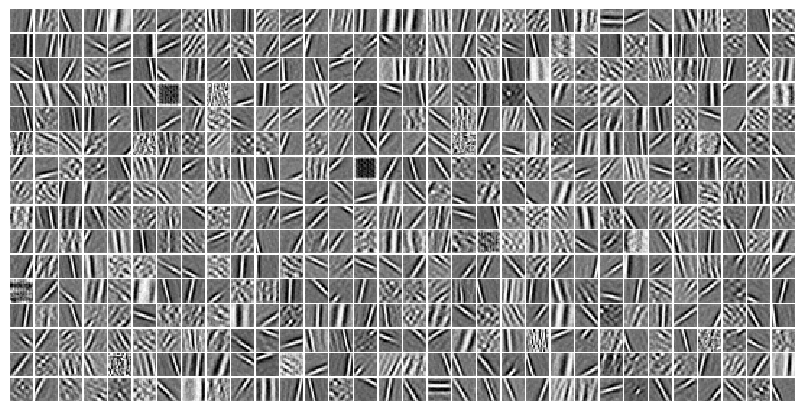

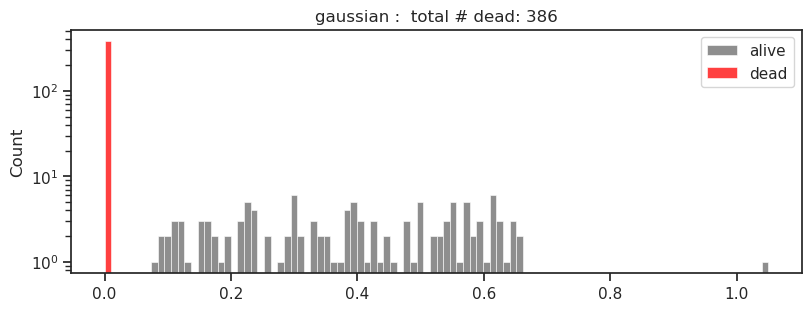

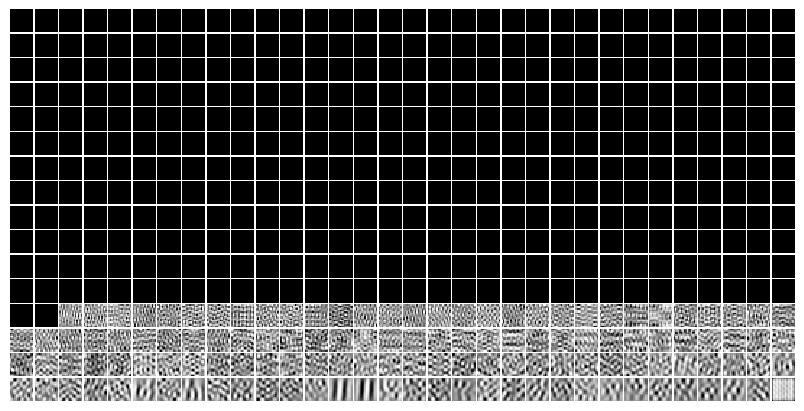

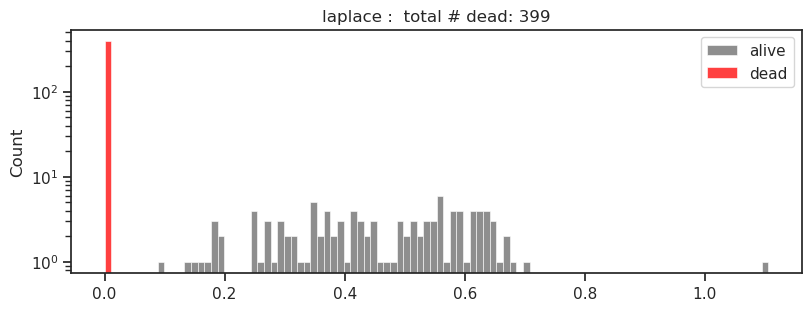

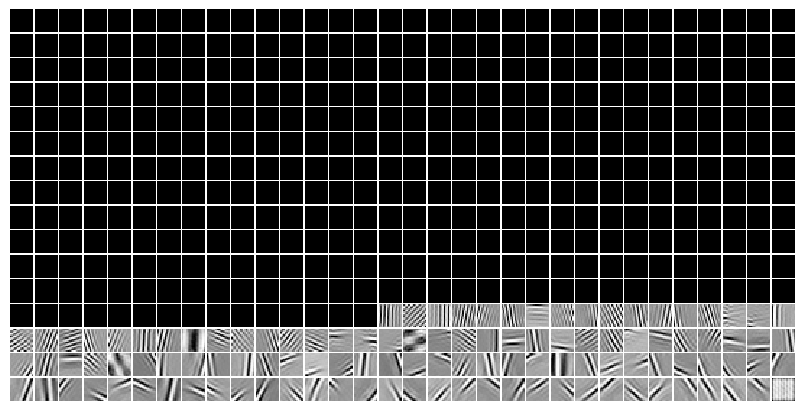

In [8]:
for name, tr in trainers.items():
    data, loss, etc = tr.validate()
    dead = tr.find_dead_neurons(loss['kl_diag'])

    msg = f"{name} :  total # dead: {dead.sum()}"
    if tr.model.cfg.type == 'categorical':
        print(msg)
        tr.model.show(dpi=100)
        continue

    w_dec = tonp(tr.model.fc_dec.weight)
    norms = sp_lin.norm(w_dec, axis=0)
    w_dec = w_dec.T.reshape(-1, 16, 16)

    kl = loss['kl_diag']
    order = np.argsort(kl)
    
    w_dec = w_dec[order]
    norms = norms[order]
    dead = dead[order]
    kl = kl[order]

    fig, ax = create_figure(1, 1, (8, 3))
    bins = np.linspace(0, max(kl), 101)
    sns.histplot(kl[~dead], bins=bins, color='dimgrey', label='alive', ax=ax)
    sns.histplot(kl[dead], bins=bins, color='r', label='dead', ax=ax)
    ax.locator_params(axis='x', nbins=11)
    ax.set(yscale='log')
    ax.set_title(msg)
    ax.legend()
    plt.show()

    _ = plot_weights(w_dec, scaling=(~dead).astype(float), dpi=100)

In [84]:
name = 'poisson'
tr = trainers[name]
data, loss, etc = tr.validate()
dead = tr.find_dead_neurons(
    order=np.argsort(loss['kl_diag']),
    frac=8,
)

In [85]:
kl = loss['kl_diag']
order = np.argsort(kl)

dead_thres = -10.0
dead = np.log(kl) < dead_thres

msg = f"{name} :  total # dead: {dead.sum()}"

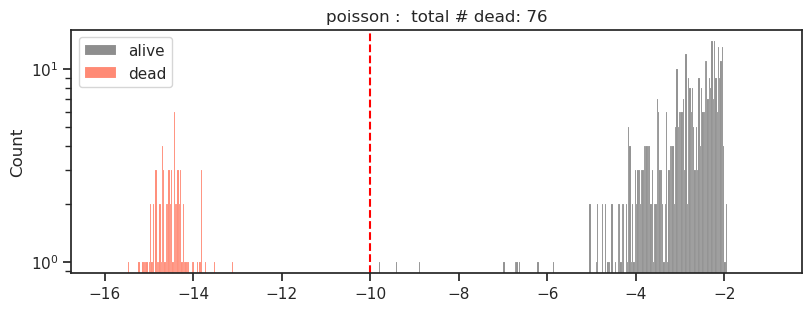

In [86]:
fig, ax = create_figure(1, 1, (8, 3))
bins = np.linspace(-16, -1, 512)
sns.histplot(np.log(kl)[~dead], bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(np.log(kl)[dead], bins=bins, color='tomato', label='dead', ax=ax)
ax.axvline(dead_thres, color='r', ls='--')
ax.locator_params(axis='x', nbins=11)
ax.set(yscale='log')
ax.set_title(msg)
ax.legend()
plt.show()

In [49]:
w_dec = tonp(tr.model.fc_dec.weight)
w_dec = w_dec.T.reshape(-1, 16, 16)
w_dec = w_dec[order]
dead = dead[order]
kl = kl[order]

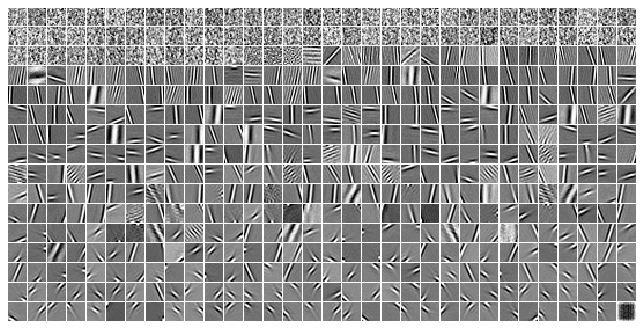

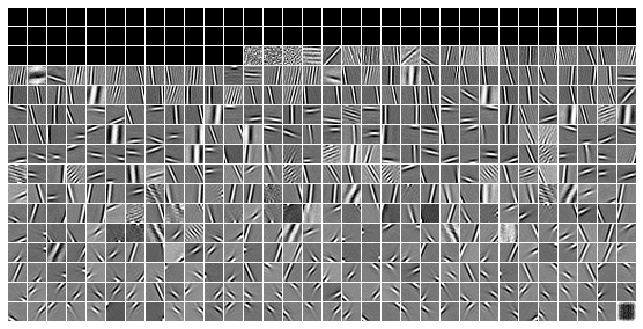

In [50]:
tr.model.show(order=order, dpi=80)
_ = plot_weights(w_dec, scaling=(~dead).astype(float), dpi=80)

In [148]:
def find_dead_neurons(
        self,
        kl: np.ndarray = None,
        frac: float = None, ):
    if self.model.cfg.type == 'categorical':
        dead = self.model.find_dead_neurons(frac or 2)
    else:
        # dead = self.model.find_dead_neurons(frac or 8)
        if kl is None:
            loss = self.validate()[1]
            kl = loss['kl_diag']

        log_kl = np.log(kl)
        nbins = len(log_kl) * 12
        hist, bin_edges = np.histogram(
            log_kl, bins=nbins)

        find_last_contiguous_zeros(hist > 0, window)
        
        i, j = critical_ids(hist > 0)
        
        dead = log_kl < bin_edges[i]
        # order = np.argsort(kl)
        # idx = np.argmax(~dead[order])
        # dead = np.zeros(len(dead))
        # dead[order[:idx]] = 1
        # dead = dead
    return hist, bin_edges

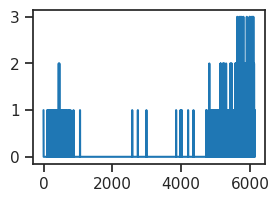

In [149]:
hist, bin_edges = find_dead_neurons(tr)
plt.plot(hist)

In [150]:
www = range(80, 1500)
outcome = []
for window in www:
    idx = find_last_contiguous_zeros(hist > 0, window)
    dead = np.log(kl) < bin_edges[idx]
    outcome.append(dead.sum())

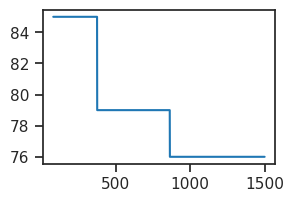

In [151]:
plt.plot(www, outcome);

In [90]:
def find_last_contiguous_zeros(mask, window):
    # Reverse the array to search from the end
    reversed_mask = mask[::-1]
    
    # Track the length of contiguous zeros found
    zero_count = 0
    
    # Index in the reversed array where the last contiguous zeros start
    for index, value in enumerate(reversed_mask):
        if value == 0:
            zero_count += 1
        else:
            zero_count = 0  # Reset count if a non-zero is found
        
        # Check if we've found enough contiguous zeros
        if zero_count == window:
            # Return the index of the last zero in the original array
            return len(mask) - (index - window + 2)  # Adjusting for the reverse and zero-based index
        
    # Return -1 if no such segment is found
    return -1

# Example usage
mask = np.array([...])  # your 512-length array
window = 64
index_of_last_zero = find_last_contiguous_zeros(mask, window)
print(index_of_last_zero)


-1

In [6]:
tr = trainers['categorical']
data, loss, etc = tr.validate()

order = np.argsort(loss['kl_diag'])

In [7]:
# dead_thres = 0.008
# dead = loss['kl_diag'] < dead_thres

# r_prior = tr.model.log_rate.squeeze().exp()[order]
# rdr_post = etc['r*dr'][:, order]
# kl = loss['kl_diag'][order]
# dead = dead[order]

norms = torch.linalg.vector_norm(
    tr.model.fc_dec.weight, dim=0)
norms = tonp(norms) # [order]

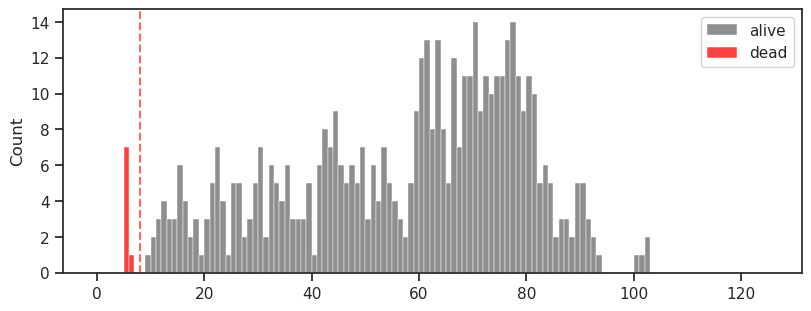

In [120]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 125, 126)
sns.histplot(kl[~dead] * 1000, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(kl[dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

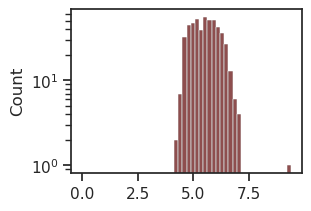

In [11]:
fig, ax = create_figure()
sns.histplot(norms, color='red', alpha=1.0, bins=np.linspace(0, max(norms), 51), ax=ax)
sns.histplot(norms, color='dimgrey', bins=np.linspace(0, max(norms), 51), ax=ax)
ax.set(yscale='log')
ax.ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [25]:
hist, bin_edges = np.histogram(norms, bins=512//2)
hist.shape, bin_edges.shape

((256,), (257,))

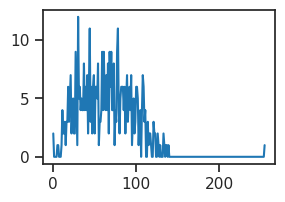

In [26]:
plt.plot(hist)

In [27]:
i, j = critical_ids(hist > 0)
dead = np.logical_or(
    norms < bin_edges[i],
    norms > bin_edges[j],
)
dead.sum()

3

In [28]:
hist

array([ 2,  0,  0,  0,  0,  1,  1,  0,  0,  0,  1,  4,  2,  2,  3,  1,  3,
        3,  6,  3,  5,  7,  2,  4,  5,  2,  2,  9,  5,  1, 12,  5,  6,  4,
        5,  4,  4,  8,  4,  6,  4,  7,  2,  6, 11,  3,  6,  2,  6,  7,  2,
        6,  6,  5,  8,  1,  3,  3,  4,  9,  4,  9,  5,  4,  7,  4,  8,  2,
        9,  6,  9,  4,  4,  8,  1,  4,  3,  9, 11,  4,  2,  5,  6,  6,  6,
        4,  6,  2,  5,  7,  3,  5,  6,  4,  7,  1,  3,  5,  2,  3,  6,  6,
        5,  1,  3,  4,  0,  4,  7,  6,  3,  4,  0,  0,  3,  1,  2,  2,  1,
        0,  0,  3,  2,  2,  0,  0,  2,  1,  0,  1,  0,  0,  0,  2,  1,  0,
        1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [88]:
with torch.inference_mode():
    y = tr.to(etc['r*dr'])
    y = tr.model.decode(y)
    mse_true = tr.model.loss_recon(
        y, tr.dl_vld.dataset.tensors[0])
    mse_true = mse_true.mean()
mse_true

tensor(102.3971, device='cuda:3')

In [105]:
perf_drop = []
for i in tqdm(range(etc['r*dr'].shape[1])):
    y = tr.to(etc['r*dr'])
    # y[:, i] = tr.model.log_rate.squeeze().exp()[i]
    y[:, i] = 0
    with torch.inference_mode():
        y = tr.model.decode(y)
        mse = tr.model.loss_recon(
            y, tr.dl_vld.dataset.tensors[0])
        mse = mse.mean()
    diff = (mse - mse_true) / mse_true
    perf_drop.append(diff.item())
perf_drop = np.array(perf_drop)

100%|████████████████████████████████████████| 512/512 [00:02<00:00, 193.63it/s]


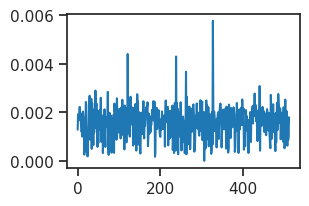

In [106]:
plt.plot(perf_drop)

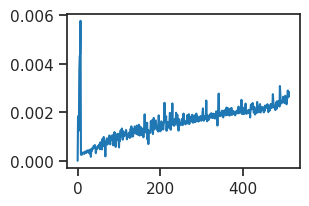

In [107]:
plt.plot(perf_drop[order])

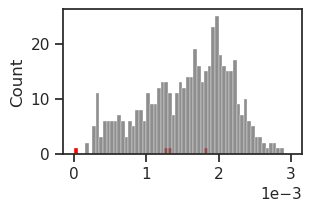

In [108]:
fig, ax = create_figure()
sns.histplot(perf_drop[order][dead], color='red', alpha=1.0, bins=np.linspace(0, 3e-3, 61), ax=ax)
sns.histplot(perf_drop[order][~dead], color='dimgrey', bins=np.linspace(0, 3e-3, 61), ax=ax)
ax.ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [109]:
perf_drop[order][dead] * 1000

array([0.00834489, 1.83960097, 1.3081358 , 1.25024316, 3.66959046,
       4.29493561, 4.39738389, 5.76199684])

In [110]:
perf_drop[order][~dead] * 1000

array([0.26234245, 0.25243289, 0.27761658, 0.27545585, 0.34087381,
       0.34675995, 0.32768591, 0.31874495, 0.29438085, 0.3773827 ,
       0.38304529, 0.33156032, 0.33498768, 0.33185835, 0.42849514,
       0.42499328, 0.38505701, 0.42819712, 0.43430677, 0.34690896,
       0.43132645, 0.30570605, 0.32701532, 0.47595671, 0.17233686,
       0.46545107, 0.40740939, 0.50933624, 0.53921394, 0.4983836 ,
       0.534967  , 0.62892149, 0.56097028, 0.60649461, 0.65224245,
       0.58235403, 0.3239605 , 0.45852186, 0.52684563, 0.55314694,
       0.51403028, 0.58958132, 0.63100772, 0.60709065, 0.67876728,
       0.60656911, 0.4844506 , 0.76609058, 0.52438688, 0.65388164,
       0.77413744, 0.47841546, 0.90303621, 0.61126309, 0.73718152,
       0.98752824, 0.80155639, 0.79343503, 0.71728788, 0.19096384,
       0.78181177, 0.81884221, 0.89290313, 0.93514909, 0.67533995,
       0.82182256, 0.82674006, 0.92993357, 0.85482956, 1.05130696,
       0.73785207, 0.68316329, 0.93142374, 0.86548418, 0.99311

In [111]:
r_prior[dead]

tensor([2.5622e-03, 3.0846e+01, 2.8446e+01, 2.8007e+01, 3.7702e+01, 4.0020e+01,
        4.0464e+01, 4.4980e+01], device='cuda:3', grad_fn=<IndexBackward0>)

In [112]:
rdr_post.mean(0)[dead]

array([7.3596481e-03, 2.7007235e+01, 2.5182674e+01, 2.4843483e+01,
       3.2024986e+01, 3.3652393e+01, 3.3959991e+01, 3.7035423e+01],
      dtype=float32)

In [113]:
np.round(rdr_post.mean(0)[dead])

array([ 0., 27., 25., 25., 32., 34., 34., 37.], dtype=float32)

In [114]:
np.exp(etc['log_dr'].mean(0)[dead])

array([0.8893265 , 0.90071034, 0.9269079 , 0.8868576 , 0.95502365,
       0.9315644 , 0.9019006 , 0.8923952 ], dtype=float32)

In [97]:
rdr_post.mean(0)[~dead]

array([0.02129017, 0.02027241, 0.02348023, 0.03098642, 0.04558562,
       0.05710728, 0.03734353, 0.04135868, 0.03026808, 0.07138067,
       0.05501949, 0.0341549 , 0.02769154, 0.044504  , 0.0705558 ,
       0.06808687, 0.05800052, 0.08030989, 0.06371398, 0.03717802,
       0.06241561, 0.03466726, 0.06564683, 0.09381076, 0.04042164,
       0.09838137, 0.05129551, 0.09186185, 0.13339499, 0.06971648,
       0.10299862, 0.16113959, 0.11937854, 0.11148805, 0.15794729,
       0.13704756, 0.0439693 , 0.06514561, 0.0669421 , 0.09895577,
       0.11215455, 0.07780098, 0.12573373, 0.10377932, 0.16550137,
       0.10287789, 0.06766462, 0.26170754, 0.11448638, 0.12880498,
       0.23737901, 0.05879541, 0.24594045, 0.08933517, 0.14162788,
       0.26777834, 0.2293457 , 0.1961039 , 0.12486452, 0.06074248,
       0.22732748, 0.25769228, 0.2809928 , 0.26218712, 0.11115866,
       0.15666878, 0.24387181, 0.25256813, 0.23683506, 0.25374675,
       0.15238176, 0.15731888, 0.24803583, 0.22632955, 0.22533

In [ ]:
def forward_modified(
        self,
        dl_name: str,
        temp: float = None,
        use_ema: bool = False,
        knock_out: Sequence[int] = None,
        knock_out_val: float = 0.0,
        full_data: bool = False, ):
    assert dl_name in ['trn', 'vld', 'tst']
    dl = getattr(self, f"dl_{dl_name}")
    if dl is None:
        return
    model = self.select_model(use_ema)
    if temp is None:
        temp = model.temp

    mse, kl, kl_diag = [], [], []
    x_all, y_all, z_all, g_all = [], [], [], []
    etc = collections.defaultdict(list)

    for x in iter(dl):
        if len(x) == 2:
            x, g = x
        else:
            g = None
        if isinstance(x, (tuple, list)):
            x = x[0]
        if x.device != self.device:
            x = self.to(x)
        if self.model.cfg.type == 'poisson':
            dist, log_dr, z, y = model.xtract_ftr(x, temp)
            _kl = model.loss_kl(log_dr)
            etc['log_dr'].append(tonp(log_dr))
            etc['r*dr'].append(tonp(dist.rate))
        elif self.model.cfg.type in [
                'gaussian', 'laplace', 'categorical']:
            dist, z, y = model.xtract_ftr(x, temp)
            _kl = model.loss_kl(dist)
            if self.model.cfg.type == 'categorical':
                etc['logits'].append(tonp(dist.logits))
            else:
                etc['loc'].append(tonp(dist.loc))
                etc['scale'].append(tonp(dist.scale))
        else:
            raise ValueError(self.model.cfg.type)
        # data
        if full_data or dl_name == 'trn':
            x_all.append(tonp(x))
            y_all.append(tonp(y))
            if g is not None:
                g_all.append(tonp(g))
        z_all.append(tonp(z))
        # loss
        mse.append(tonp(model.loss_recon(y, x)))
        kl.append(tonp(torch.sum(_kl, dim=1)))
        kl_diag.append(tonp(torch.mean(
            _kl, dim=0, keepdim=True)))

    x, y, z, g, mse, kl, kl_diag = cat_map(
        [x_all, y_all, z_all, g_all, mse, kl, kl_diag])
    data = {'x': x, 'y': y, 'z': z, 'g': g}
    loss = {'mse': mse, 'kl': kl, 'kl_diag': kl_diag.mean(0)}
    etc = {k: np.concatenate(v) for k, v in etc.items()}
    return data, loss, etc

In [3]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'lin|lin')
cfg_tr['method'] = 'exact'
cfg_vae['seed'] = 2990

vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [4]:
x, *_ = next(iter(tr.dl_trn))

In [5]:
mse, dist, _ = vae.loss_recon_exact(x)

In [6]:
mse.shape

torch.Size([200])

In [5]:
dist = vae.infer(x[:3], t=1e-8)

In [6]:
from base.distributions import Categorical

rng = get_rng()
probs = rng.gamma(2, 1, size=(200, 10))
probs = probs / probs.max()
probs /= probs.sum(-1, keepdims=True)
dist = Categorical(logits=torch.logit(torch.tensor(probs)), temp=0)

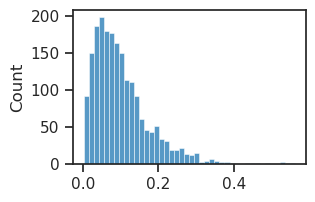

In [7]:
sns.histplot(tonp(dist.probs.ravel()))
plt.show()

In [8]:
samples = dist.sample((100000,))

In [9]:
mu, var = samples.mean(0), samples.var(0)

In [13]:
torch.round(mu - dist.mean, decimals=2)

tensor([[0., 0., -0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., -0.,  ..., 0., -0., 0.],
        ...,
        [-0., 0., 0.,  ..., -0., 0., -0.],
        [-0., 0., -0.,  ..., -0., -0., -0.],
        [0., -0., 0.,  ..., -0., -0., 0.]], dtype=torch.float64)

In [12]:
torch.round(var - dist.variance, decimals=2)

tensor([[0., 0., -0.,  ..., 0., -0., 0.],
        [-0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., -0.,  ..., 0., -0., 0.],
        ...,
        [-0., 0., 0.,  ..., -0., 0., -0.],
        [-0., 0., -0.,  ..., -0., -0., -0.],
        [0., -0., 0.,  ..., -0., -0., 0.]], dtype=torch.float64)

In [11]:
var[b, 0, c], variance[b, 0, c]

(tensor(0.0021, device='cuda:3'),
 tensor(0.0021, device='cuda:3', grad_fn=<SelectBackward0>))

In [15]:
torch.round(var - variance, decimals=3)

tensor([[[-0., 0., -0.,  ..., -0., -0., 0.]],

        [[0., -0., 0.,  ..., -0., -0., 0.]],

        [[0., 0., -0.,  ..., -0., 0., -0.]]], device='cuda:3',
       grad_fn=<RoundBackward1>)

In [5]:
mse, dist, _ = vae.loss_recon_exact(x)

NotImplementedError: 

In [9]:
dist.mean

NotImplementedError: 

In [10]:
dist.probs.shape

torch.Size([200, 1, 512])

In [12]:
samples = dist.sample((10000, ))
samples.shape

torch.Size([10000, 200, 1, 512])

/home/hadi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

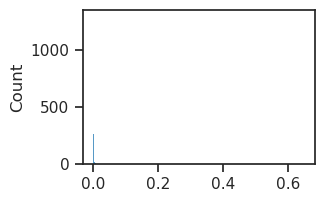

In [13]:


sns.histplot(tonp(samples[:, b, 0, c]))

In [14]:
mu, sd = samples.mean(0), samples.std(0)

In [16]:
mu[b, 0, c], dist.probs[b, 0, c]

(tensor(0.0018, device='cuda:3'),
 tensor(0.0017, device='cuda:3', grad_fn=<SelectBackward0>))

In [ ]:
tr.train()

epoch # 74, avg loss: 76.134607:   6%|▍       | 74/1200 [04:15<56:44,  3.02s/it]

In [3]:
print(torch.cuda.is_available())
print(f"torch: {torch.__version__}\tcuda: {torch.version.cuda}\tcudnn: {torch.backends.cudnn.version()}")
print()

True

torch: 2.3.0    cuda: 12.1      cudnn: 8902

In [4]:
torch.backends.cudnn.benchmark = True

In [5]:
import torch
from torch import nn
x = nn.Parameter(torch.randn(123, 16, 64, 64), requires_grad=True).cuda()
conv = nn.Conv2d(16, 32, 3, 1).cuda()
y = conv(x)
loss = (y - 1).pow(2).sum()
loss.backward()

In [ ]:
# torch.backends.cudnn.deterministic = True

In [5]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|lin')
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

In [ ]:
tr.train()

epoch # 956, avg loss: 40.660207:  80%|█████████████████▌    | 956/1200 [4:21:21<1:03:34, 15.63s/it]

epoch # 20, avg loss: 129.306015:   2%|▍                        | 20/1200 [03:30<3:51:05, 11.75s/it]

In [5]:
### Was: mach

  0%|                                                                      | 0/1200 [00:00<?, ?it/s]/home/hadi/Dropbox/git/_PoissonVAE/base/common.py:353: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(
/home/hadi/anaconda3/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
epoch # 4, avg loss: 53.324352:   0%|                            | 4/1200 [01:19<6:

KeyboardInterrupt: 

In [5]:
### Was: solo

epoch # 5, avg loss: 53.524626:   0%|                            | 5/1200 [01:02<4:07:08, 12.41s/it]


KeyboardInterrupt: 

In [3]:
conv_no_warn = nn.Conv2d(8, 3, kernel_size=3, stride=1, padding=0).eval().cuda()
conv_warn = nn.Conv2d(8, 1, kernel_size=3, stride=1, padding=0).eval().cuda()
x = torch.rand((1, 8, 546, 392)).cuda()

with torch.inference_mode(), torch.autocast(device_type="cuda"):
    # No warning
    conv_no_warn(x)
    # UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED
    conv_warn(x)

In [4]:
print(torch.cuda.is_available())
print(f"torch: {torch.__version__}\tcuda: {torch.version.cuda}\tcudnn: {torch.backends.cudnn.version()}")
print()

True

torch: 2.3.0    cuda: 11.8      cudnn: 8700

In [5]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.enabled

True

In [6]:
import torch
from torch import nn
x = nn.Parameter(torch.randn(123, 16, 64, 64), requires_grad=True).cuda()
conv = nn.Conv2d(16, 32, 3, 1).cuda()
y = conv(x)
loss = (y - 1).pow(2).sum()
loss.backward()

In [7]:
cfg_vae, cfg_tr = default_configs('MNIST', model_type, 'conv+b|conv+b')
print(f"VAE:\n{cfg_vae}\n\nTrainer:\n{cfg_tr}")

VAE:
{'dataset': 'MNIST', 'n_ch': 32, 'n_latents': 10, 'prior_clamp': -2, 'fit_prior': True, 'enc_type': 'conv', 
'dec_type': 'conv', 'enc_bias': True, 'dec_bias': True, 'init_dist': 'StudentT', 'init_scale': 0.1}

Trainer:
{'lr': 0.002, 'epochs': 1200, 'batch_size': 200, 'warm_restart': 2, 'optimizer_kws': {'weight_decay': 0.0003}, 
'grad_clip': 1000, 'kl_const_portion': 0.01}

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
|  PoissonVAE |  6.2 Mil   |
|     ---     |    ---     |
|     stem    |    352     |
|     enc     |  4.9 Mil   |
|    fc_enc   |   2.6 K    |
|    fc_dec   |   11.3 K   |
|     dec     |  1.2 Mil   |
+-------------+------------+

poisson_uniform_c(-2)_MNIST_z-10_k-32_fp_<conv+b|conv+b>
mc_b200-ep1200-lr(0.002)_beta(1:0x0.5)_temp(0.05:lin-0.5)_gr(1000)_(2024_05_09,03:23)

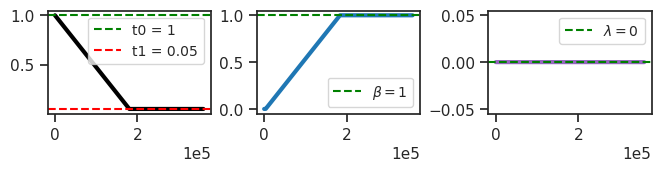

In [8]:
vae = MODEL_CLASSES[model_type](CFG_CLASSES[model_type](**cfg_vae))
tr = TrainerVAE(vae, ConfigTrainVAE(**cfg_tr), device=device)

vae.print()
print(f"{vae.cfg.name()}\n{tr.cfg.name()}_({vae.timestamp})\n")
tr.show_schedules()

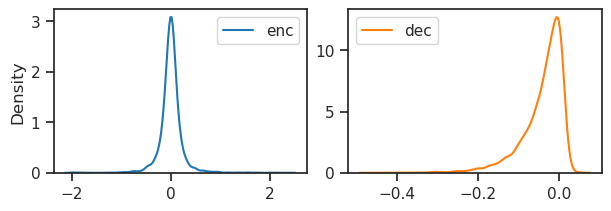

In [9]:
fig, axes = create_figure(1, 2)
sns.kdeplot(tonp(vae.fc_enc.weight.data.ravel()), label='enc', color='C0', ax=axes[0])
sns.kdeplot(tonp(vae.fc_dec.weight.data.ravel()), label='dec', color='C1', ax=axes[1])
axes[1].set_ylabel('')
add_legend(axes)
plt.show()

In [ ]:
comment = f"testing_{tr.cfg.name()}"
# comment = tr.cfg.name()
tr.train(comment=comment)

epoch # 36, avg loss: 85.353015:   3%|▊                         | 36/1200 [11:33<6:00:35, 18.59s/it]

In [ ]:
tr.show_recon(0.0), tr.show_samples(0.0);

In [12]:
tr.dl_vld.dataset.tensors

(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [13]:
data, loss, etc = tr.validate()

_loss = {k: v.mean() for k, v in loss.items()}
_loss['tot'] = _loss['mse'] + _loss['kl']
print(_loss)

{'mse': 31.922916, 'kl': 65.528015, 'kl_diag': 6.5528016, 'tot': 97.45093}

In [ ]:
df, df_summary = knn_analysis(
    x=etc['log_dr'],
    y=tonp(tr.dl_vld.dataset.tensors[1]),
    n_iter=100,
    verbose=True,
)

In [ ]:
df_summary